### [Semi-supervised Learning](https://scikit-learn.org/stable/modules/semi_supervised.html)
- Used in situations where some of your training data is not labeled.
- Scikit-Learn expects an identifier to mark unlabeled points during training; this implementation uses integer -1.
- Semi-supervised algorithms need assumptions about the dataset distribution for effective use. [Wikipedia](https://en.wikipedia.org/wiki/Semi-supervised_learning#Assumptions_used)

### [Self-Training Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.SelfTrainingClassifier.html#sklearn.semi_supervised.SelfTrainingClassifier)
- Based on [Yarowsky's algorithm](https://doi.org/10.3115/981658.981684).
- Can be called with any classifier (specified with `base_classifier`) that can return `predict_proba`. The classifier predicts labels for unlabeled data with each iteration & adds a subset of the predictions to the labeled dataset.
- The subset choice is controlled by `threshold` (of prediction probabilities) or the `k_best` samples.
- The labels used in the final fit, and the iteration on which each label was labeled as available, are attributes.
- `max_iter` controls algorithm execution time.

### Example: [Threshold vs Self-Training Performance](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_self_training_varying_threshold.html#sphx-glr-auto-examples-semi-supervised-plot-self-training-varying-threshold-py)
- Labels are deleted from the `breast_cancer` dataset - only 50  of the 569 samples are labeled.
- **top graph**: number of labeled samples, and accuracy score, vs threshold value.
- **bottom graph**: number of iterations at which a sample is labeled.
- Values are 3-fold cross validated.
- At thresholds `0.4..0.5`, classifier is learning from low-confidence labels - so the accuracy is poor. 
- At thresholds `0.9..1.0`, the classifier quits adding to its dataset.
- Optimal accuracy is around 0.7.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.semi_supervised import SelfTrainingClassifier as STC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

In [2]:
n_splits      = 3
X, y          = datasets.load_breast_cancer(return_X_y=True)
X, y          = shuffle(X, y, random_state=42)
y_true        = y.copy()
y[50:]        = -1
total_samples = y.shape[0]

base_clf = SVC(probability=True, gamma=0.001, random_state=42)

x_values          = np.arange(0.4, 1.05, 0.05)
x_values          = np.append(x_values, 0.99999)
scores            = np.empty((x_values.shape[0], n_splits))
amount_labeled    = np.empty((x_values.shape[0], n_splits))
amount_iterations = np.empty((x_values.shape[0], n_splits))

- Manual cross validation required so that -1 isn't treated as a separate class when computing accuracy...

In [3]:
for (i, threshold) in enumerate(x_values):
    self_training_clf = STC(base_clf, threshold=threshold)
    
    skfolds = SKF(n_splits=n_splits)
    for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
        X_train     = X[train_index]
        y_train     = y[train_index]
        X_test      = X[test_index]
        y_test      = y[test_index]
        y_test_true = y_true[test_index]

        self_training_clf.fit(X_train, y_train)

        # #labeled samples post-fit
        amount_labeled[i, fold] = total_samples - np.unique(
            self_training_clf.labeled_iter_, 
            return_counts=True)[1][0]
        
        # The last iteration the classifier labeled a sample in
        amount_iterations[i, fold] = np.max(
            self_training_clf.labeled_iter_)

        y_pred          = self_training_clf.predict(X_test)
        scores[i, fold] = accuracy_score(y_test_true, y_pred)

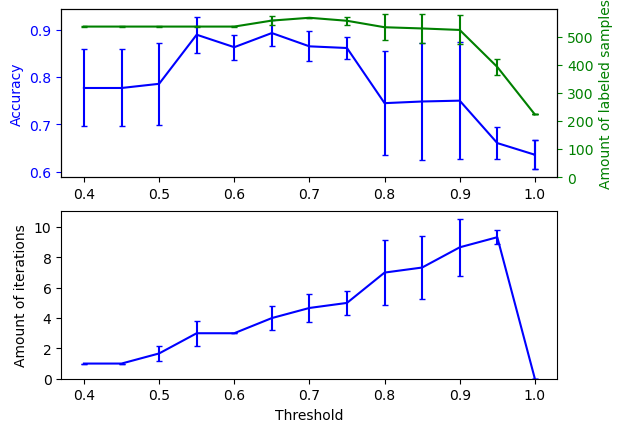

In [4]:
ax1 = plt.subplot(211)
ax1.errorbar(x_values, 
             scores.mean(axis=1),
             yerr=scores.std(axis=1),
             capsize=2, color='b')

ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.errorbar(x_values, 
             amount_labeled.mean(axis=1),
             yerr=amount_labeled.std(axis=1),
             capsize=2, color='g')

ax2.set_ylim(bottom=0)
ax2.set_ylabel('Amount of labeled samples', color='g')
ax2.tick_params('y', colors='g')

ax3 = plt.subplot(212, sharex=ax1)
ax3.errorbar(x_values, 
             amount_iterations.mean(axis=1),
             yerr=amount_iterations.std(axis=1),
             capsize=2, color='b')

ax3.set_ylim(bottom=0)
ax3.set_ylabel('Amount of iterations')
ax3.set_xlabel('Threshold')

plt.show()

### [Example: Comparison of decision boundaries: Label Spreading, Self-Training & SVM](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_semi_supervised_versus_svm_iris.html#sphx-glr-auto-examples-semi-supervised-plot-semi-supervised-versus-svm-iris-py)
- Demonstrates LS & ST can learn reasonable boundaries even when small amounts of labeled data are available.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.semi_supervised import LabelSpreading as LS
from sklearn.semi_supervised import SelfTrainingClassifier as STC

In [6]:
iris = datasets.load_iris(); X = iris.data[:, :2]; y = iris.target
h    = .02 # mesh step size
rng  = np.random.RandomState(0)
y_rand = rng.rand(y.shape[0])
y_30   = np.copy(y)
y_30[y_rand < 0.3] = -1  # set random samples to be unlabeled
y_50  = np.copy(y)
y_50[y_rand < 0.5] = -1

In [7]:
ls30  = (LS().fit(X, y_30), y_30, 'Label Spreading 30% data')
ls50  = (LS().fit(X, y_50), y_50, 'Label Spreading 50% data')
ls100 = (LS().fit(X, y),    y,    'Label Spreading 100% data')

base_clf = SVC(kernel='rbf', gamma=.5, probability=True)
st30 = (STC(base_clf).fit(X, y_30), y_30, 'Self-training 30% data')
st50 = (STC(base_clf).fit(X, y_50), y_50, 'Self-training 50% data')

rbf_svc = (SVC(kernel='rbf', gamma=.5).fit(X,y),y, 'SVC with rbf kernel')

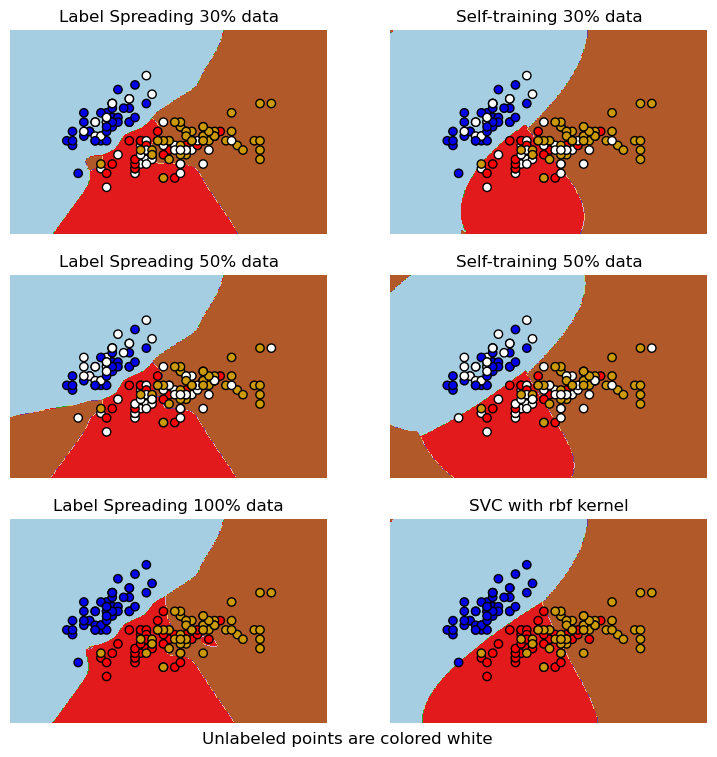

In [8]:
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

color_map = {-1: (1, 1, 1), 
              0: (0, 0, .9), 
              1: (1, 0, 0), 
              2: (.8, .6, 0)}

classifiers = (ls30, st30, ls50, st50, ls100, rbf_svc)

plt.figure(figsize=(9,9))

for i, (clf, y_train, title) in enumerate(classifiers):
    # Plot the decision boundary.
    plt.subplot(3, 2, i + 1)
    Z = clf.predict(np.c_[xx.ravel(), 
                          yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis('off')

    # Training points
    colors = [color_map[y] for y in y_train]
    plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='black')

    plt.title(title)

plt.suptitle("Unlabeled points are colored white", y=0.1)
plt.show()

### [Label Propagation](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html#sklearn.semi_supervised.LabelPropagation) & [Label Spreading](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html#sklearn.semi_supervised.LabelSpreading)
- LP & LS both construct a *similarity graph* over all items in the dataset.
- LP uses the raw similarity graph with no modifications, and "hard clamps" input labels (setting $\alpha=0$)
- LS minimizes a loss function with regularization, which aids with robustness to noise. It uses a modified version of the original graph & normalizes edge weights via a normalized *graph Laplacian matrix*.
- LP models have two built-in kernels; the choice effects both scalability and performance.
    - *rbf* (keyword "gamma"): $\exp(-\gamma |x-y|^2), \gamma>0$
        - Returns a fully connected graph (a dense matrix).
        - Matrix size + full matrix multiplication during each iteration means this option can lead to long runtimes.
    - *knn* (keyword "n_neighbors"): $1[x' \in kNN(x)]$
        - Returns a sparse matrix = shorter runtimes.

### [Example: Label Propagation on Complex Structure](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_structure.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-structure-py)
- Outer circle label: "red"; inner circle label: "blue"

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.semi_supervised import LabelSpreading as LS
from sklearn.datasets import make_circles

In [10]:
n            = 200
X, y         = make_circles(n_samples=n, shuffle=False)
outer, inner = 0, 1
labels       = np.full(n, -1.)
labels[0]    = outer
labels[-1]   = inner

In [11]:
label_spread = LS(kernel='knn', alpha=0.8)
label_spread.fit(X, labels)

LabelSpreading(alpha=0.8, kernel='knn')

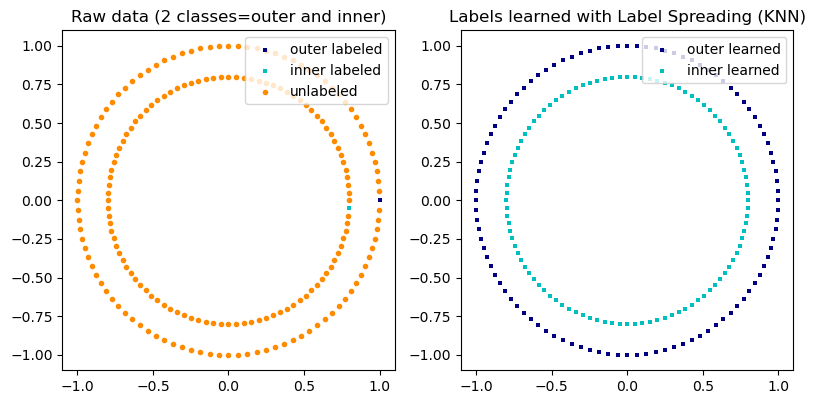

In [12]:
output_labels      = label_spread.transduction_
output_label_array = np.asarray(output_labels)
outer_numbers      = np.where(output_label_array == outer)[0]
inner_numbers      = np.where(output_label_array == inner)[0]

plt.figure(figsize=(8.5, 4))
plt.subplot(1, 2, 1)

plt.scatter(X[labels == outer, 0], 
            X[labels == outer, 1], 
            color='navy', marker='s', lw=0, label="outer labeled", s=10)
plt.scatter(X[labels == inner, 0], 
            X[labels == inner, 1], 
            color='c',    marker='s', lw=0, label='inner labeled', s=10)
plt.scatter(X[labels ==    -1, 0], 
            X[labels ==    -1, 1], 
            color='darkorange', marker='.', label='unlabeled')

plt.legend(scatterpoints=1, shadow=False, loc='upper right')
plt.title("Raw data (2 classes=outer and inner)")

plt.subplot(1, 2, 2)

plt.scatter(X[outer_numbers, 0], 
            X[outer_numbers, 1], 
            color='navy', marker='s', lw=0, s=10, label="outer learned")
plt.scatter(X[inner_numbers, 0], 
            X[inner_numbers, 1], 
            color='c',    marker='s', lw=0, s=10, label="inner learned")

plt.legend(scatterpoints=1, shadow=False, loc='upper right')
plt.title("Labels learned with Label Spreading (KNN)")

plt.subplots_adjust(left=0.07, bottom=0.07, right=0.93, top=0.92)
plt.show()

### [Example: Digits Classification with Label Spreading](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-digits-py)
- Digits dataset = 1797 points, only 30 will be labeled.
- Results returned in a confusion matrix.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import datasets
from sklearn.semi_supervised import LabelSpreading as LS
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import classification_report as CR

In [14]:
digits  = datasets.load_digits()
rng     = np.random.RandomState(2)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

X             = digits.data[indices[:340]]
y             = digits.target[indices[:340]]
images        = digits.images[indices[:340]]
n_total       = len(y)
n_labeled     = 40
indices       = np.arange(n_total)
unlabeled_set = indices[n_labeled:]
y_train       = np.copy(y) # Shuffle everything
y_train[unlabeled_set] = -1

In [15]:
lp_model = LS(gamma=.25, max_iter=20)
lp_model.fit(X, y_train)
predicted_labels = lp_model.transduction_[unlabeled_set]
true_labels = y[unlabeled_set]

cm = CM(true_labels, predicted_labels, labels=lp_model.classes_)

print("Label Spreading: %d labeled & %d unlabeled points (%d total)" %
      (n_labeled, n_total - n_labeled, n_total))

print(CR(true_labels, predicted_labels))
print("Confusion matrix")
print(cm)

# Calculate uncertainty values for each transduced distribution
pred_entropies = stats.distributions.entropy(
    lp_model.label_distributions_.T)

# Pick the top 10 most uncertain labels
uncertainty_index = np.argsort(pred_entropies)[-10:]

Label Spreading: 40 labeled & 300 unlabeled points (340 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.82      1.00      0.90        37
           2       1.00      0.86      0.92        28
           3       1.00      0.80      0.89        35
           4       0.92      1.00      0.96        24
           5       0.74      0.94      0.83        34
           6       0.89      0.96      0.92        25
           7       0.94      0.89      0.91        35
           8       1.00      0.68      0.81        31
           9       0.81      0.88      0.84        24

    accuracy                           0.90       300
   macro avg       0.91      0.90      0.90       300
weighted avg       0.91      0.90      0.90       300

Confusion matrix
[[27  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  1 24  0  0  0  2  1  0  0]
 [ 0  0  0 28  0  5  0  1  0  1]
 [ 0  0  0  0 24  0  0  0  0 

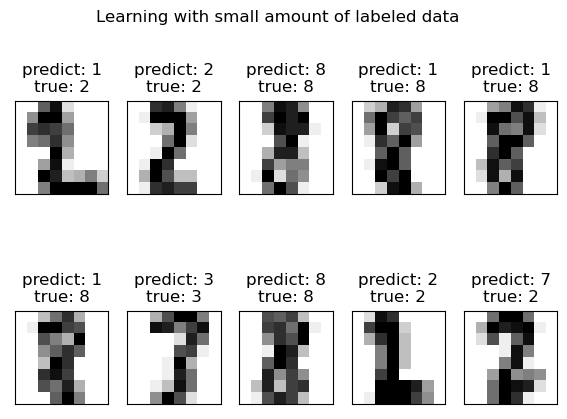

In [16]:
f = plt.figure(figsize=(7, 5))
for index, image_index in enumerate(uncertainty_index):
    image = images[image_index]

    sub = f.add_subplot(2, 5, index + 1)
    sub.imshow(image, cmap=plt.cm.gray_r)
    plt.xticks([])
    plt.yticks([])
    sub.set_title('predict: %i\ntrue: %i' % (
        lp_model.transduction_[image_index], y[image_index]))

f.suptitle('Learning with small amount of labeled data')
plt.show()